# Finding a detection strategy

The dataset consists of 8303 videos, adding to a total of XX:XX:XX hours of footage. All video and audio channels were extracted and recoded, h264 codec with a frame rate of 30FPS for videos and pcm_s16le with a bitrate of 16k for a mono channeled audio.

For all videos it is required to obtain a bounding box of any present face for every frame. The GPU-backed face detector model allows to efficiently process many frames on little time. Still, running the face detector for every frame adds to a lengthy operation. The face detector is agnostic to detections on the surrounding frames leading to gaps and jittering. The first presents itself with succesive high-frequency detections that sharply change the bounding box coordinates, while the second situation is the abscence of a bounding box of a tracked face for a short period of time.

An extrapolation strategy is needed to fill any existing gaps and may mitigate jittering by smoothing the transition between detected points. Due to their availability spline interpolators of zeroth, first, second and third order were compared with sampling rates of 15, 7, and 4 FPS to build the interpolated models.

+ Does lowering the frame rate make an improovement on detection time?
    + By how much?
    + Thresholding the frame size to a maximum value may help too, what dimensions to use as threshold?
+ Averaging past detections decrease the jittering?
    + Which performs the best?
+ Which interpolation strategy is closer to the true detection?
    + Which is closer to the softened detection?

In [1]:
%matplotlib inline
import json
from datetime import timedelta
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Speedup by lowering frame rate

The following test corroborate that frame detection can be sped-up by lowering the detection frame rate. For this analysis a sample of 150 files were randomly chosen and procesed with different frame rates.

In [2]:
experiments = [
    {'folder': r'D:/downloads/tracks@30FPS', 'label': '30FPS'},
]

for d in experiments:
    d['video_length'] = []
    d['time_detecting'] = []
    d['width'] = []
    d['height'] = []
    d['track_length'] = []
    
    for track_file in Path(d['folder']).glob('**/*.tracks.json'):
        with track_file.open('r', encoding='utf8') as fp:
            track_file = json.load(fp)
        
        if len(track_file['tracks']) == 0:
            continue
        
        # Video data
        d['video_length'].append(track_file['video_duration'])
        d['time_detecting'].append(track_file['detection_duration'])
        d['width'].append(track_file['width'])
        d['height'].append(track_file['height'])
        d['track_length'].extend([t['time'][-1] for t in track_file['tracks'].values()])

    print(f"{d['label']}:")
    print('  - Total video length:', timedelta(seconds=sum(d['video_length'])))
    print('  - Total time detecting:', timedelta(seconds=sum(d['time_detecting'])))
    print('  - Total track length:', timedelta(seconds=sum(d['track_length'])))

30FPS:
  - Total video length: 14:36:48.266667
  - Total time detecting: 9:16:27.999673
  - Total track length: 11 days, 7:31:39.533333


Mean speedup @30FPS: 2.1356564


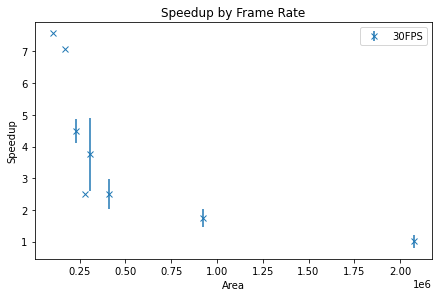

In [3]:
fig = plt.figure()
ax = plt.axes()

for d in experiments:
    all_area = np.float32(d['width']) * np.float32(d['height'])
    all_speedup = np.float32(d['video_length']) / np.float32(d['time_detecting'])
    
    print(f'Mean speedup @{d["label"]}:', np.mean(all_speedup))
    
    area = np.sort(np.unique(all_area))
    speedup = [np.mean(all_speedup[all_area == i]) for i in area]
    speedup_err = [np.std(all_speedup[all_area == i]) for i in area]
    ax.errorbar(area, speedup, yerr=speedup_err, fmt='x', label=d['label'])

fig.tight_layout()
plt.title('Speedup by Frame Rate')
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

## Track Data
We use only the 30FPS, subsampling to the lower frame rates using time.

In [4]:
DATA_PATH = Path(r'D:/downloads/tracks@30FPS')
DATA_FRAME_RATE = 30
DATA_PERIOD = 1.0 / float(DATA_FRAME_RATE)

data_time = []
data_bbox = []
data_kpts = []
data_tlen = []

for track_file in DATA_PATH.glob('**/*.tracks.json'):
    with track_file.open('r', encoding='utf8') as fp:
        track_file = json.load(fp)
    
    # Ignore videos without tracks
    if len(track_file['tracks']) == 0:
        continue
        
    track_time, track_bbox, track_kpts = zip(*[(t['time'], t['bbox'], t['kpts']) for t in track_file['tracks'].values()])
        
    track_time = list(track_time)
    track_bbox = list(track_bbox)
    track_kpts = list(track_kpts)
    track_tlen = []
    
    for i, (t, b, k) in enumerate(zip(track_time, track_bbox, track_kpts)):        
        # All tracks start from 0
        t = np.float32(t) - t[0]
        track_time[i] = t.tolist()
        
        # Length of a track in seconds
        track_tlen.append(t[-1])
        
        # Box positions from screen center
        b = np.float32(b).reshape(-1, 2, 2)
        b[:, :, 0] -= 0.5 * track_file['width']
        b[:, :, 1] -= 0.5 * track_file['height']
        track_bbox[i] = b.tolist()
        
        # Point positions from screen center
        k = np.float32(k).reshape(-1, 5, 2)
        k[:, :, 0] -= 0.5 * track_file['width']
        k[:, :, 1] -= 0.5 * track_file['height']
        track_kpts[i] = k.tolist()
    
    data_time.extend(track_time)
    data_bbox.extend(track_bbox)
    data_kpts.extend(track_kpts)
    data_tlen.extend(track_tlen)

num_tracks = len(data_time)
print('There are', num_tracks, 'tracks')

There are 1182 tracks


### Sampling tracks
Pick random track and a starting point.

In [5]:
SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 1000
np.random.seed(0)

# Pick random track and a random position to start a slice
track_samples = (np.random.random(SAMPLE_NUM) * len(data_time)).astype(int)
track_start = np.random.random(SAMPLE_NUM) * (np.float32(data_tlen)[track_samples] - SAMPLE_LENGTH)

test_time = []
test_bbox = []
test_kpts = []

for ti, ts in zip(track_samples, track_start):
    t_time = []
    t_bbox = []
    t_kpts = []
    # Add the frames that lie between the picked slice bounds
    for i in range(len(data_time[ti])):
        if ts <= data_time[ti][i] < ts + SAMPLE_LENGTH:
            t_time.append(data_time[ti][i])
            t_bbox.append(data_bbox[ti][i])
            t_kpts.append(data_kpts[ti][i])
    # Make slices start from 0
    test_time.append(np.float32(t_time) - t_time[0])
    test_bbox.append(np.float32(t_bbox))
    test_kpts.append(np.float32(t_kpts))

## Compensating for the jittering
30FPS is too high-frequency, it introduces jittering.

Jittering is an undesired problem on the high-frequency 30FPS tracked boxes used as reference samples. Applying a moving window averaging the previous elements acts as a low-pass filter reducing the jitter. Three weighting strategies were used: uniform, lineal and gaussian.

+ Uniform estrategy averages the last n elements with equal weights.
+ Linear strategy weights the elements by the time-distance to the current sample, normalized by the longest.
+ Gaussian strategy weights by the gaussian value on the time-axis, centered on the current sample with a standard deviation of the detection period.

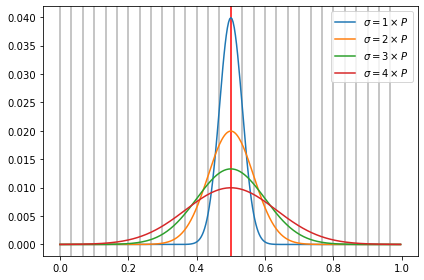

In [6]:
def gaussian(x, mu, sigma):
    return (1.0 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

fig = plt.figure()
ax = plt.axes()

for x in np.arange(0, 1, DATA_PERIOD):
    if x == 0.5:
        color = 'red'
    else:
        color = '#0f0f0f50'
    plt.axvline(x=x, color=color)

x = np.arange(0, 1, DATA_PERIOD / 10.0)
for i in range(1, 5):
    y = gaussian(x, 0.5, DATA_PERIOD * i)
    y = y / np.sum(y)
    ax.plot(x, y, label=f'$\sigma={i} \\times P$')

fig.tight_layout()
plt.legend()
plt.show()

On the previous figure, the vertical lines are equally distance by the time between frames, or period $P$. For the third previous element, its contribution is close to zero.

Thus the weight of element $j$ with respect to element $i$ is:
$
W(t_j, t_i)=
\begin{cases}
    \frac{1}{P \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{t_j-t_i}{P})^2} & \forall j <= i\\
    0 & \text{otherwise}.
\end{cases}
$

We show its effects on distance and area

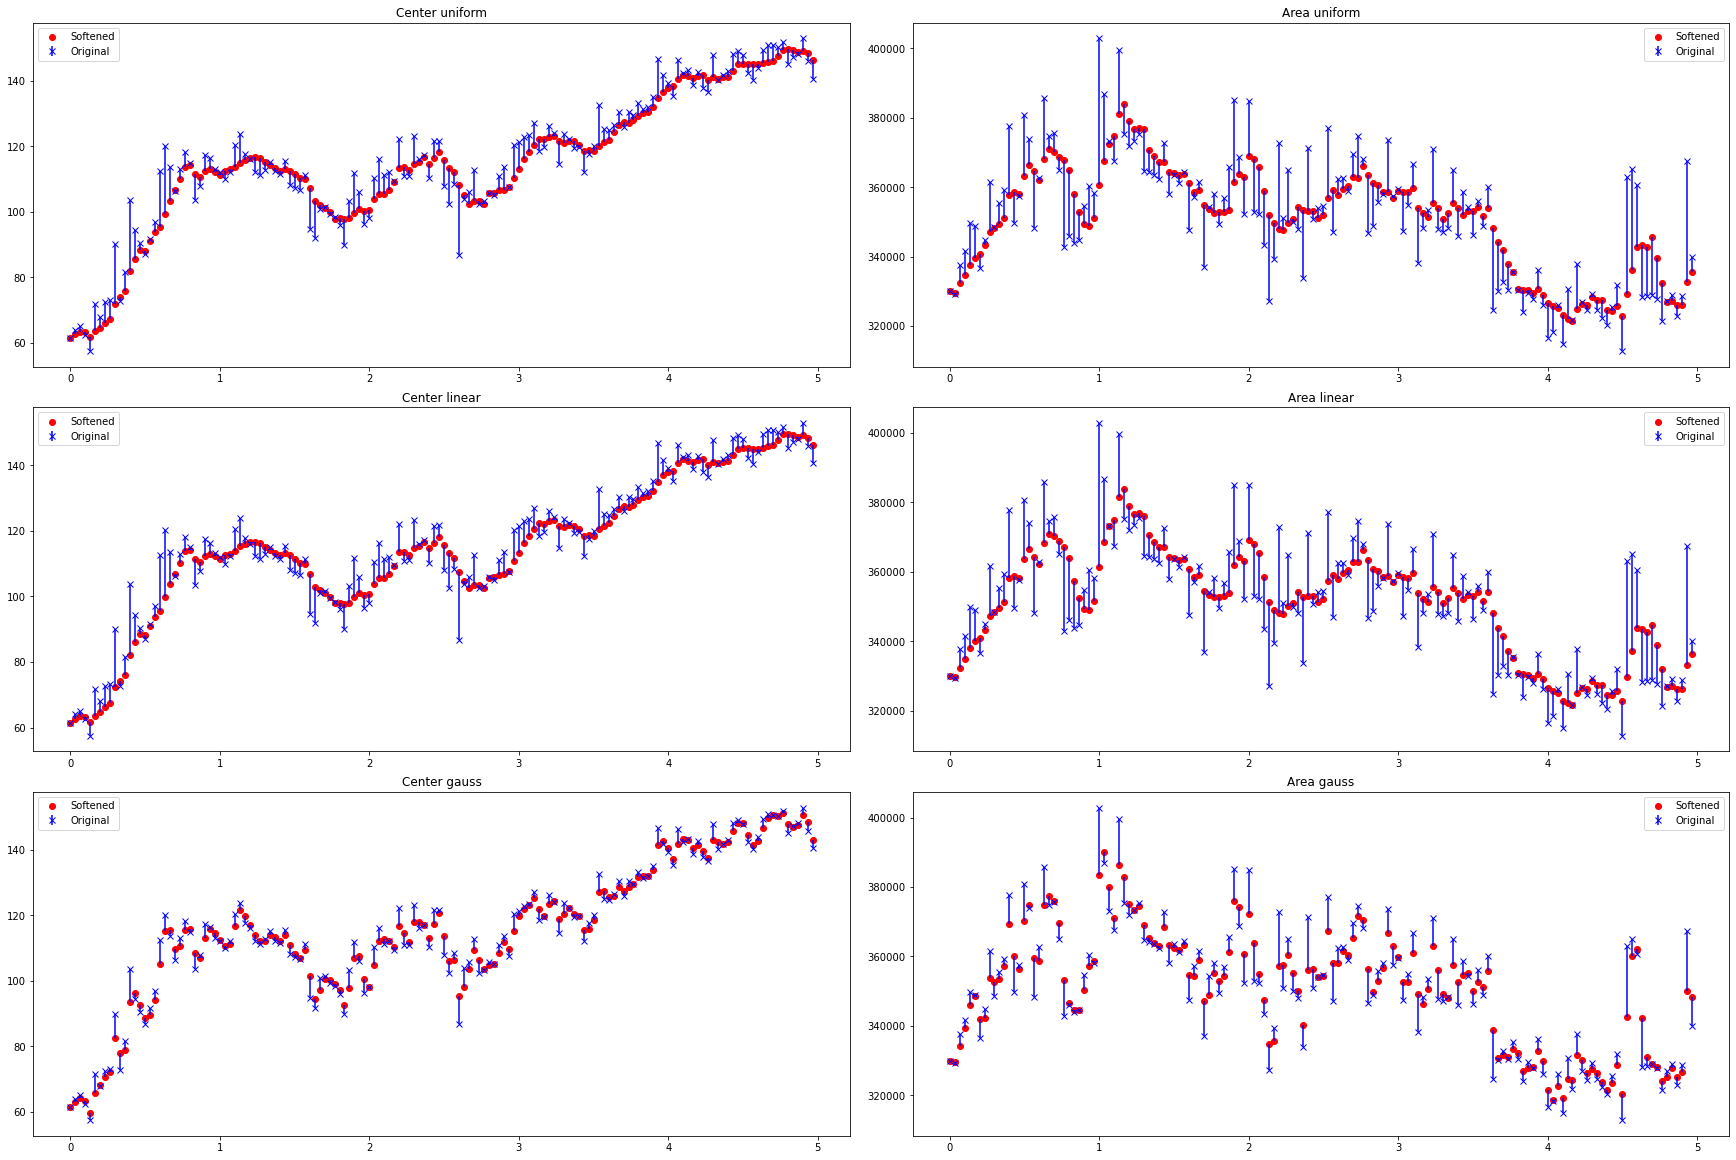

In [14]:
def soften(x, y, win_size, fn):
    soft_y = []
    for c in range(len(x)):
        istart = max(c - win_size, 0)
        iend = c + 1
        # iend = min(c + win_size, len(x)-1)
        weights = fn(x[istart:iend])
        weights = weights / np.sum(weights)
        soft_y.append(np.average(y[istart:iend], weights=weights, axis=0))
    return np.float32(soft_y)

test_cases = { 
    'uniform': lambda x: np.ones_like(x),
    'linear': lambda x: 1.0 / (np.abs(x - x[-1]) + 1.0),
    'gauss': lambda x: gaussian(x, x[-1], DATA_PERIOD),
}

k = 1

true_time = test_time[k]
true_bbox = test_bbox[k]
cter = np.sqrt(np.sum((0.5 * np.sum(true_bbox, axis=1))**2, axis=-1))
area = (true_bbox[:, 1, 0] - true_bbox[:, 0, 0]) * (true_bbox[:, 1, 1] - true_bbox[:, 0, 1])

soft_fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(24, 16), constrained_layout=True, squeeze=False)
for i, (label, op) in enumerate(test_cases.items()):
    cter_ax = axs[i, 0]
    area_ax = axs[i, 1]
    
    soft_bbox = soften(true_time, true_bbox, 5, op)
    soft_cter = np.sqrt(np.sum((0.5 * np.sum(soft_bbox, axis=1))**2, axis=-1))
    soft_area = (soft_bbox[:, 1, 0] - soft_bbox[:, 0, 0]) * (soft_bbox[:, 1, 1] - soft_bbox[:, 0, 1])
    
    lcter = cter - soft_cter
    ucter = -lcter
    lcter[lcter < 0] = 0
    ucter[ucter < 0] = 0

    larea = area - soft_area
    uarea = -larea
    larea[larea < 0] = 0
    uarea[uarea < 0] = 0

    # Plot softened data with the displacement from True with an error bar
    cter_ax.errorbar(true_time, cter, yerr=(lcter, ucter), linestyle='None', color='b', marker='x', label='Original')
    area_ax.errorbar(true_time, area, yerr=(larea, uarea), linestyle='None', color='b', marker='x', label='Original')
    cter_ax.scatter(true_time, soft_cter, color='red', label='Softened')
    area_ax.scatter(true_time, soft_area, color='red', label='Softened')

    cter_ax.set_title('Center ' + label)
    cter_ax.legend()
    area_ax.set_title('Area ' + label)
    area_ax.legend()
            

In [ ]:
def select_times(in_times, in_period, out_period):
    out_times = np.round(in_times / in_period).astype(int)
    k = int(np.round(out_period / in_period))
    out_times = np.mod(out_times, k)
    return np.argwhere(out_times == 0)

test_case = [
    {'label': '15FPS', 'period': 1.0/15.0},
    {'label': '7FPS', 'period': 1.0/7.0},
    {'label': '3FPS', 'period': 1.0/3.0},
]





INTERPOLATION_TYPE = ['zero', 'slinear', 'quadratic', 'cubic']
kind = 'quadratic'
nrows, ncols = (1, 1)


rnd = (np.random.random(nrows * ncols) * len(test_time)).astype(int)

fig, axs = plt.subplots(nrows=2 * nrows, ncols=ncols, figsize=(16, 8), constrained_layout=True, squeeze=False)

for i in range(ncols):
    for j in range(nrows):
        cetr_ax = axs[2 * j, i]
        area_ax = axs[2 * j + 1, i]
        
        cetr_ax.set_title('Centers')
        area_ax.set_title('Area')
        
        k = rnd[i * nrows + j]
        true_time = test_time[k]
        true_bbox = test_bbox[k]
        soft_bbox = soften(true_time, true_bbox, 5, 1.0 / 30.0)
        
        true_cetr = np.sqrt(np.sum((0.5 * np.sum(true_bbox, axis=1))**2, axis=-1))
        true_area = (true_bbox[:, 1, 0] - true_bbox[:, 0, 0]) * (true_bbox[:, 1, 1] - true_bbox[:, 0, 1])
        soft_cetr = np.sqrt(np.sum((0.5 * np.sum(soft_bbox, axis=1))**2, axis=-1))
        soft_area = (soft_bbox[:, 1, 0] - soft_bbox[:, 0, 0]) * (soft_bbox[:, 1, 1] - soft_bbox[:, 0, 1])
        
        # Centering
        # true_cetr = true_cetr - np.mean(true_cetr)
        # true_area = true_area - np.mean(true_area)
        # soft_cetr = soft_cetr - np.mean(soft_cetr)
        # soft_area = soft_area - np.mean(soft_area)
        
        lcetr = soft_cetr - true_cetr
        ucetr = -lcetr
        lcetr[lcetr < 0] = 0
        ucetr[ucetr < 0] = 0
        
        larea = soft_area - true_area
        uarea = -larea
        larea[larea < 0] = 0
        uarea[uarea < 0] = 0
        
        # Plot softened data with the displacement from True with an error bar
        cetr_ax.errorbar(true_time, soft_cetr, yerr=(lcetr, ucetr), linestyle='None', color='b', marker='x', label='Data')
        area_ax.errorbar(true_time, soft_area, yerr=(larea, uarea), linestyle='None', color='b', marker='x', label='Data')

        # x = time[select_times(time, 1.0/float(base_frame_rate), 1.0/3.0)]
        # x = np.arange(0, 5 + base_frame_rate, base_frame_rate)
        # x = np.linspace(0, 5, num=int(np.ceil(5 * base_frame_rate)), endpoint=True)
        for t_frame_rate in test_frame_rate:
            k = select_times(true_time, 1.0 / float(base_frame_rate), 1.0 / float(t_frame_rate))
        #     t_time = time[k].flatten()
        #     t_bctr = bctr[k].flatten()
        #     t_area = area[k].flatten()
        #     
        #     bbox_inter = interp1d(t_time, t_bctr, kind=kind, bounds_error=False)
        #     area_inter = interp1d(t_time, t_area, kind=kind, bounds_error=False)
        #     axs[2 * j, i].plot(x, bbox_inter(x), label=kind)
        #     axs[2 * j + 1, i].plot(x, area_inter(x), label=kind)
        
        cetr_ax.legend()
        area_ax.legend()

fig.suptitle('Interpolation Models', fontsize=16)
plt.show()